In [7]:
import numpy as np
import pandas as pd
import pingouin as pg
import matplotlib.pyplot as plt

In [8]:
cdf = pd.read_csv("gpt-4o-mini_data.csv").drop(["my_sen", "else_sen", "nice_sen", "honest_sen", "score"], axis=1)
mdf = pd.read_csv("mistral-small_data.csv").drop(["my_sen", "else_sen", "nice_sen", "honest_sen", "score"], axis=1)

cdf['model'] = 'gpt'
mdf['model'] = 'mistral'

df_all = pd.concat([cdf, mdf], ignore_index=False)

df_long = df_all.melt(
    id_vars=["i", "model"], 
    var_name="prompt",
    value_name="llm_score"
)
df_long["prompt"] = pd.Categorical(
    df_long["prompt"],
    categories=["my", "else", "nice", "honest"],
    ordered=True
)
df_long

,i,model,prompt,llm_score
0,0,gpt,my,3
1,1,gpt,my,3
2,2,gpt,my,3
3,3,gpt,my,3
4,4,gpt,my,3
...,...,...,...,...
15995,1995,mistral,honest,3
15996,1996,mistral,honest,2
15997,1997,mistral,honest,3
15998,1998,mistral,honest,3


In [9]:
aov = pg.rm_anova(
        data=df_long,
        dv      = "llm_score",          # dependent variable
        within  = ["model", "prompt"],   # two within-subject factors
        subject = "i",               # returns SS, ε, corrected p’s, etc.
     )
aov

c:\Users\Viggo\miniconda3\envs\dtu02450\Lib\site-packages\pingouin\distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
c:\Users\Viggo\miniconda3\envs\dtu02450\Lib\site-packages\pingouin\distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,model,23.87025,1,1999,23.870250,133.331460,6.642716e-30,6.642716e-30,0.004520,1.000000
1,prompt,897.93650,3,5997,299.312167,2146.294498,0.000000e+00,0.000000e+00,0.145883,0.994632
2,model * prompt,19.34325,3,5997,6.447750,50.485463,3.233439e-32,3.501000e-32,0.003666,0.998829


In [10]:
print(aov[["Source","ddof1","ddof2","SS","MS","F","p-unc","p-GG-corr","eps"]].to_latex())

\begin{tabular}{llrrrrrrrr}
\toprule
 & Source & ddof1 & ddof2 & SS & MS & F & p-unc & p-GG-corr & eps \\
\midrule
0 & model & 1 & 1999 & 23.870250 & 23.870250 & 133.331460 & 0.000000 & 0.000000 & 1.000000 \\
1 & prompt & 3 & 5997 & 897.936500 & 299.312167 & 2146.294498 & 0.000000 & 0.000000 & 0.994632 \\
2 & model * prompt & 3 & 5997 & 19.343250 & 6.447750 & 50.485463 & 0.000000 & 0.000000 & 0.998829 \\
\bottomrule
\end{tabular}



C:\Users\Viggo\AppData\Local\Temp\ipykernel_19440\870465409.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pivot = (df_long.groupby(['model', 'prompt'])['llm_score']


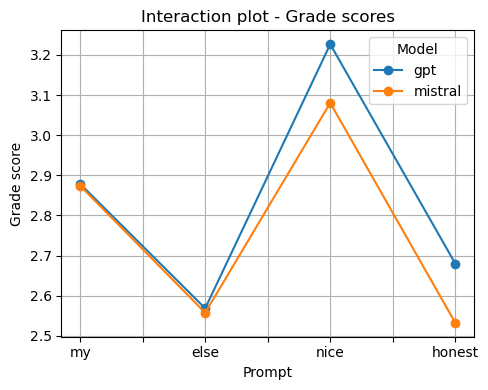

In [11]:
pivot = (df_long.groupby(['model', 'prompt'])['llm_score']
           .mean()
           .unstack('model'))       # rows = model, columns = prompt

fig, ax = plt.subplots(figsize=(5, 4))
pivot.plot(ax=ax, marker='o')

ax.set_xlabel('Prompt')
ax.set_ylabel('Grade score')
ax.set_title('Interaction plot - Grade scores')
ax.legend(title='Model')
ax.grid(True)
plt.tight_layout()
plt.savefig("interactiongrades.pdf", format="pdf")
plt.show()

In [12]:
df_long['cond'] = df_long['model'].astype(str) + '_' + df_long['prompt'].astype(str)

posthoc = pg.pairwise_tests(data=df_long,
                             dv='llm_score',
                             within='cond',          
                             subject='i',
                             parametric=True,
                             padjust='none', # We do correction ourselves       
                             effsize='cohen')        
posthoc.round(4) # We only use the 16 relevant tests of these

c:\Users\Viggo\miniconda3\envs\dtu02450\Lib\site-packages\pingouin\bayesian.py:154: RuntimeWarning: overflow encountered in scalar divide
  bf10 = 1 / ((1 + t**2 / df) ** (-(df + 1) / 2) / integr)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,cohen
0,cond,gpt_else,gpt_honest,True,True,-9.5225,1999.0,two-sided,0.0000,4.273e+17,-0.1753
1,cond,gpt_else,gpt_my,True,True,-25.8314,1999.0,two-sided,0.0000,1.861e+123,-0.4715
2,cond,gpt_else,gpt_nice,True,True,-54.6269,1999.0,two-sided,0.0000,inf,-1.0599
3,cond,gpt_else,mistral_else,True,True,0.8981,1999.0,two-sided,0.3692,0.038,0.0175
4,cond,gpt_else,mistral_honest,True,True,2.6653,1999.0,two-sided,0.0078,0.869,0.0590
5,cond,gpt_else,mistral_my,True,True,-23.2152,1999.0,two-sided,0.0000,7.666e+101,-0.4953
6,cond,gpt_else,mistral_nice,True,True,-40.4130,1999.0,two-sided,0.0000,2.188e+257,-0.8291
7,cond,gpt_honest,gpt_my,True,True,-18.6646,1999.0,two-sided,0.0000,1.098e+68,-0.3316
8,cond,gpt_honest,gpt_nice,True,True,-48.4974,1999.0,two-sided,0.0000,inf,-0.9791
9,cond,gpt_honest,mistral_else,True,True,11.1684,1999.0,two-sided,0.0000,4.343e+24,0.2164
